# Vehicle Detection with Detectron2

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Object-Detection-and-Image-Segmentation-with-Detectron2/blob/master/Detectron2_Vehicle_Detection.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Object-Detection-and-Image-Segmentation-with-Detectron2/blob/master/Detectron2_Vehicle_Detection.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [1]:
!pip install pyyaml==5.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
# !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 7.0 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=fb7c73b510116f97b63167c26484ba1b5db0d92dd719aca8291a154d40705659
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
     |████████████████████████████████| 6.4 MB 1.9 MB/s 
     |████████████████████████████████| 49 kB 4.0 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 66.5 MB/s 
     |████████████████████████████████| 130 kB 65.3 MB/s 
     |████████████████████████████████| 722 kB 59.2 MB/s 
     |████████████████████████████████| 743 kB 61.8 MB/s 
     |██

In [1]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu102 True


## Get data

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [3]:
!wget https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
!wget https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv

--2021-08-13 06:57:27--  https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.48.134
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.48.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1650810880 (1.5G) [application/x-gzip]
Saving to: ‘object-detection-crowdai.tar.gz’

object-detection-cr 100%[===================>]   1.54G  48.0MB/s    in 34s     

2021-08-13 06:58:01 (46.5 MB/s) - ‘object-detection-crowdai.tar.gz’ saved [1650810880/1650810880]

--2021-08-13 06:58:01--  https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7156250 (6.8M) [text/plain

In [4]:
!tar xf object-detection-crowdai.tar.gz

In [5]:
import pandas as pd

df = pd.read_csv('labels_crowdai.csv')

df.head()

xmin  ymin  ...  Label                                        Preview URL
0   785   533  ...    Car  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1    89   551  ...    Car  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2   268   546  ...    Car  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3   455   522  ...  Truck  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4   548   522  ...  Truck  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...

[5 rows x 7 columns]

## Register data-set

In [6]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

# write a function that loads the dataset into detectron2's standard format
def get_data_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['Frame'].map(lambda x: img_dir + x)

    classes = df['Label'].unique().tolist()

    df['class_int'] = df['Label'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for idx, filename in enumerate(df['filename'].unique().tolist()):
        record = {}
        
        #height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = 1200
        record["width"] = 1920

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [7]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = df['Label'].unique().tolist()

DatasetCatalog.register('crowdai_vehicle_detection', lambda: get_data_dicts('labels_crowdai.csv' , 'object-detection-crowdai/'))
MetadataCatalog.get('crowdai_vehicle_detection').set(thing_classes=classes)
vehicle_detection_metadata = MetadataCatalog.get('crowdai_vehicle_detection')

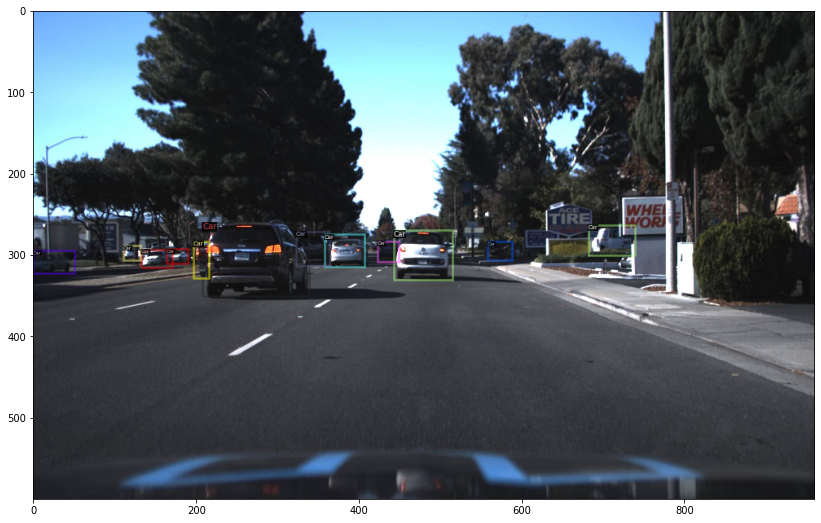

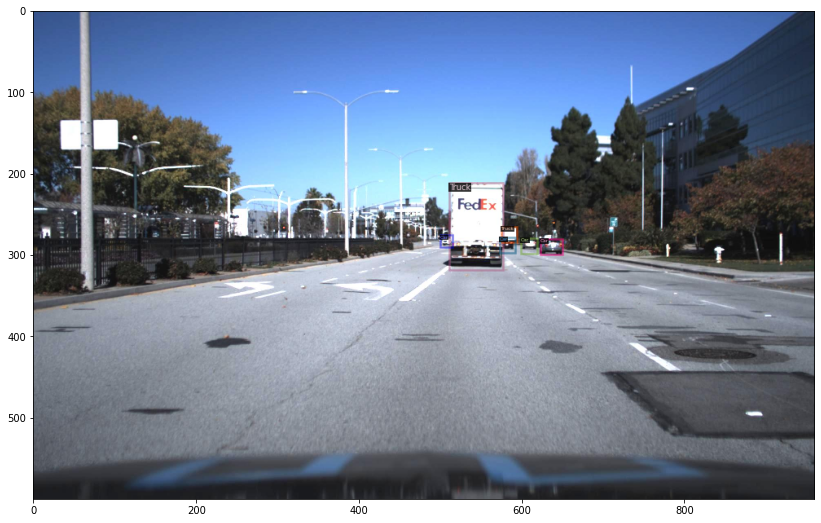

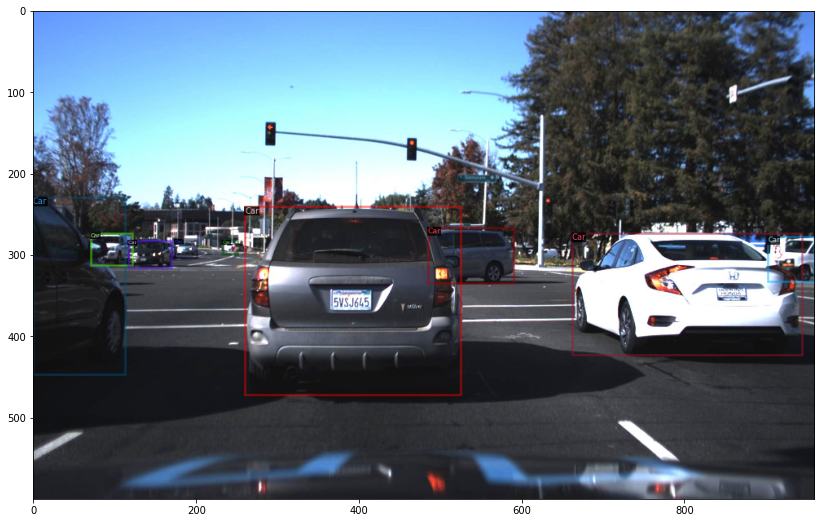

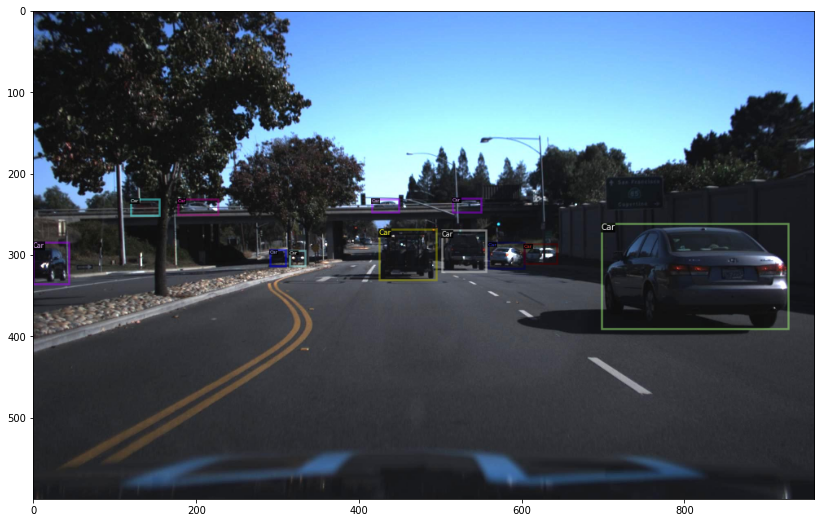

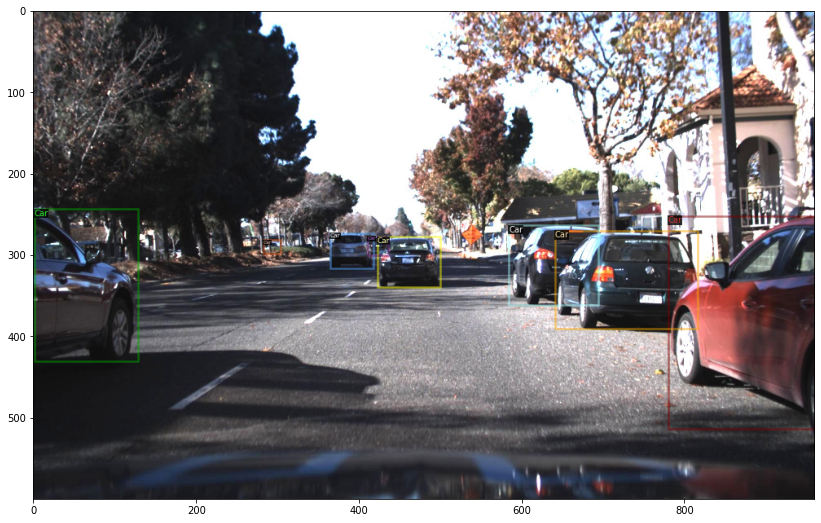

In [8]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('crowdai_vehicle_detection')
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=vehicle_detection_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Train model

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('crowdai_vehicle_detection',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/13 06:59:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:06, 40.1MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[08/13 07:00:19 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[08/13 07:00:34 d2.utils.events]:  eta: 0:10:38  iter: 19  total_loss: 1.713  loss_cls: 1.176  loss_box_reg: 0.6372  loss_rpn_cls: 0.03068  loss_rpn_loc: 0.06193  time: 0.6722  data_time: 0.0282  lr: 0.00039962  max_mem: 3669M
[08/13 07:00:48 d2.utils.events]:  eta: 0:11:08  iter: 39  total_loss: 1.113  loss_cls: 0.4207  loss_box_reg: 0.6378  loss_rpn_cls: 0.01916  loss_rpn_loc: 0.04734  time: 0.6858  data_time: 0.0099  lr: 0.00079922  max_mem: 3669M
[08/13 07:01:02 d2.utils.events]:  eta: 0:10:54  iter: 59  total_loss: 0.9145  loss_cls: 0.2857  loss_box_reg: 0.5665  loss_rpn_cls: 0.01846  loss_rpn_loc: 0.0389  time: 0.6881  data_time: 0.0090  lr: 0.0011988  max_mem: 3669M
[08/13 07:01:15 d2.utils.events]:  eta: 0:10:41  iter: 79  total_loss: 0.6806  loss_cls: 0.2392  loss_box_reg: 0.3825  loss_rpn_cls: 0.01562  loss_rpn_loc: 0.03948  time: 0.6899  data_time: 0.0110  lr: 0.0015984  max_mem: 3669M
[08/13 07:01:29 d2.utils.events]:  eta: 0:10:27  iter: 99  total_loss: 0.645  loss_cls: 0.

## Use model for inference

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

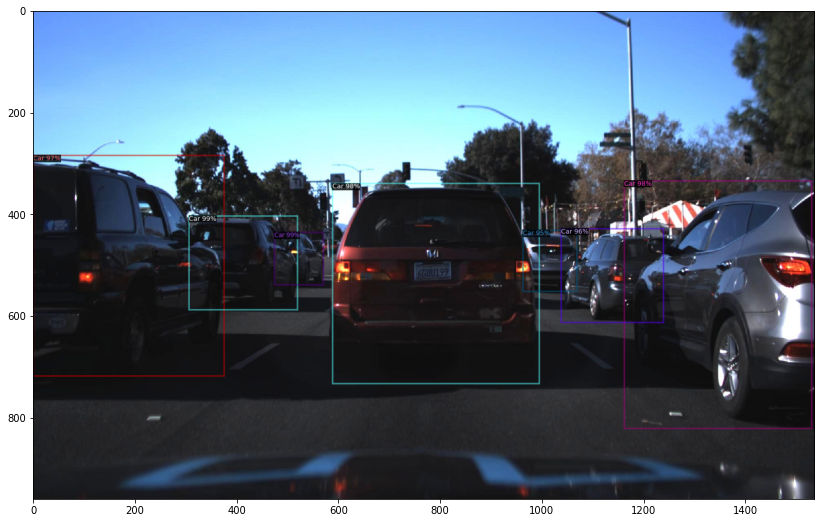

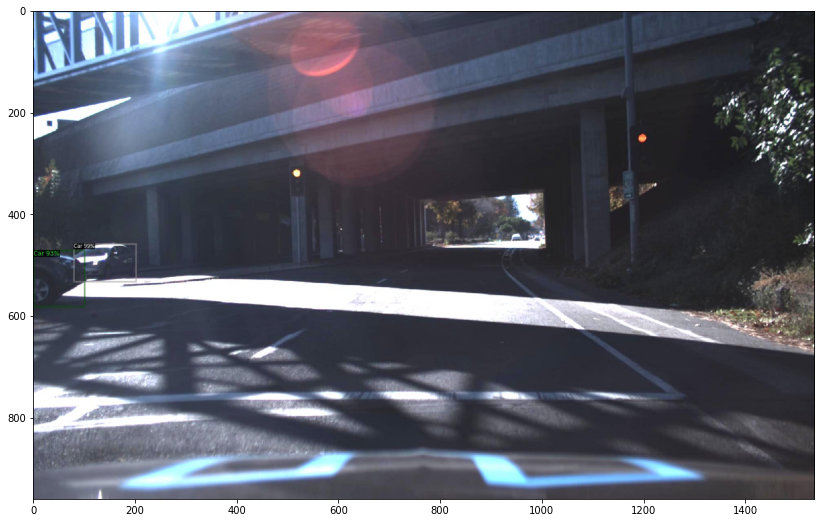

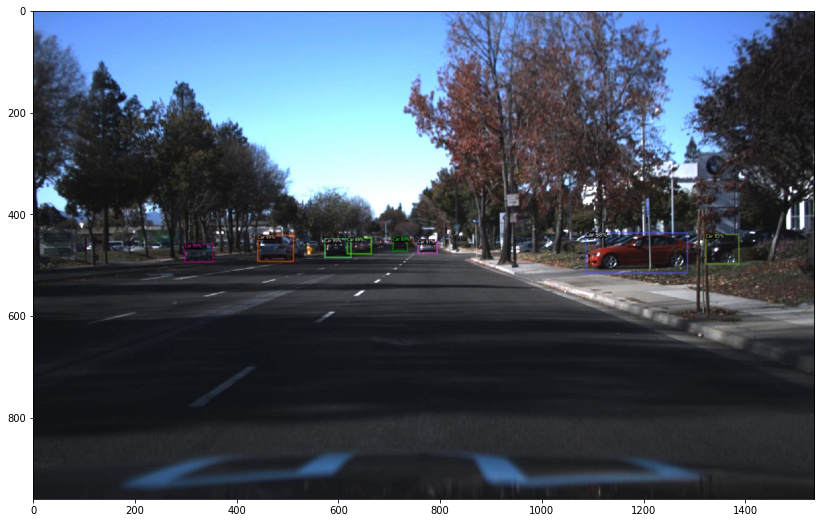

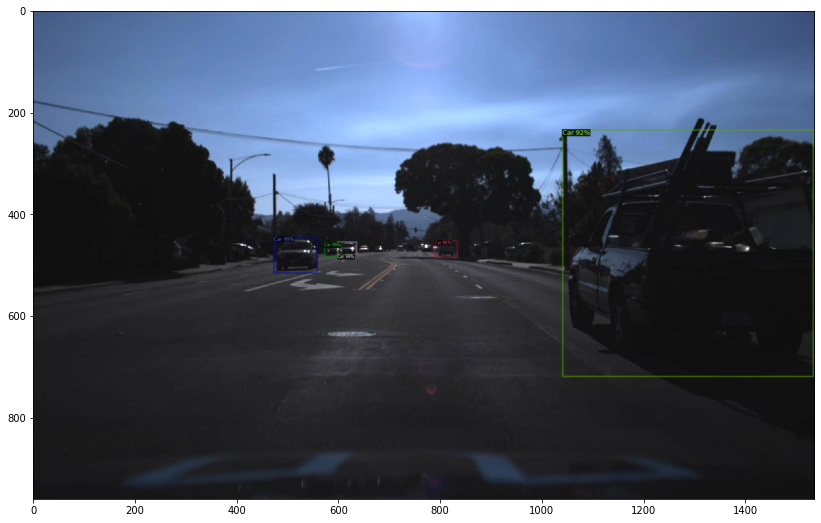

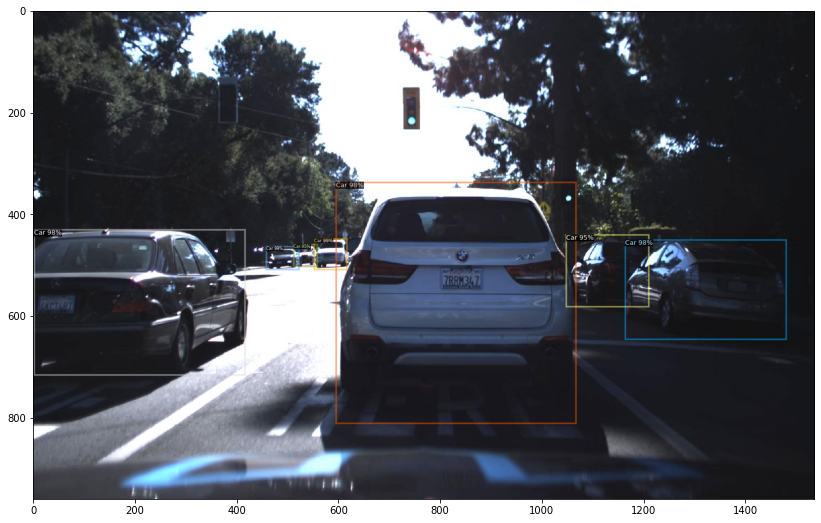

In [11]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = DatasetCatalog.get('crowdai_vehicle_detection')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=vehicle_detection_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()